# Way Home

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.patches as ptch
import seaborn as sns
import math
import pandas as pd
from copy import copy

## Set Simulation Params and Create Grid

In [2]:
person_velocity = 1 # in m/s 
car_velocitiy = 2
car_prob = 0.05 # probability that a car occurs on a lane 

n_grid = 50

In [3]:
def hit_by_car(x_car1, x_car2, x, y, car_velocity):
    if y > 1 and y <= 3:
        hit = np.any([j < x and j+car_velocity > x for j in x_car1])
    elif y > 5 and y <= 7:
        hit = np.any([j > x and j-car_velocity < x for j in x_car2])
    else:
        hit = False
        
    return hit

In [4]:
def update_car1(x_car1, car_velocity, car_prob, n_grid):
    x_car = copy(x_car1)
    x_car += car_velocity
    x_car = x_car[x_car < n_grid]
    x_car = np.append(x_car, np.array([1])[np.random.uniform(0, 1, 1)[0] < car_prob])
    
    return x_car

In [5]:
def update_car2(x_car2, car_velocity, car_prob, n_grid):
    x_car = copy(x_car2)
    x_car -= car_velocity
    x_car = x_car[x_car >= 0]
    x_car = np.append(x_car, np.array([n_grid])[np.random.uniform(0, 1, 1)[0] < car_prob])

    return x_car

In [32]:
def wayhome(maxiter, case = 'C', end_if_back = True, car_prob = 0.05, n_grid = 50, car_velocity = 2, person_velocity = 1):
    person_df = pd.DataFrame()
    car_df = pd.DataFrame()
    summary_df = pd.DataFrame()
    
    for i in range(maxiter):
        x = n_grid/2
        y = 0
        t = 0
        t_person = 0
        events_person = 0
        degree = 0
        direction = 90
        x_car1 = np.where(np.random.uniform(0, 1, n_grid) < car_prob)[0]
        x_car2 = np.where(np.random.uniform(0, 1, n_grid) < car_prob)[0]
        
        car_df = car_df.append({"iter": i,
                                "t": t, 
                                "car1": copy(x_car1), 
                                "car2": copy(x_car2)}, ignore_index = True)
        
        person_df = person_df.append({"time": t_person, 
                                      "x": x, 
                                      "y": y, 
                                      "direction": direction, 
                                      "degree": degree, 
                                      "iter": i}, ignore_index = True)
        
        hit = hit_by_car(x_car1, x_car2, x, y, car_velocity)
        
        if end_if_back:
            y_min = 1
        else:
            y_min = -np.inf
            
        while y <= 7 and not hit and (y >= y_min or np.all(person_df[person_df["iter"] == i].y < y_min)):
            t += 1
            
            x_car1 = update_car1(x_car1, car_velocity, car_prob, n_grid)
            x_car2 = update_car2(x_car2, car_velocity, car_prob, n_grid)

            car_df = car_df.append({"iter": i,
                                    "t": t, 
                                    "car1": copy(x_car1), 
                                    "car2": copy(x_car2)}, ignore_index = True)
            
            while t_person < t:

                if case == "C":
                    events_person = np.random.exponential(1, 1)[0]
                else:
                    events_person = 1

                t_person += events_person
            
                if person_df[person_df["iter"] == i].shape[0] != 1:
                    if case == "A":
                        degree = np.random.choice([-90, 0, 90], 1, p = [0.25, 0.5, 0.25])[0]
                    else:
                        degree = np.random.uniform(-120, 120, 1)[0]
                
                hit = hit_by_car(x_car1, x_car2, x, y, car_velocity)
                
                new_direction = (direction + degree)%360
                x += np.cos(np.pi * new_direction / 180) * events_person * person_velocity
                y += np.sin(np.pi * new_direction / 180) * events_person * person_velocity
                
                person_df = person_df.append({"time": t_person,
                                              "x": x, 
                                              "y": y, 
                                              "direction": direction, 
                                              "degree": degree, 
                                              "iter": i}, ignore_index = True)
                
                direction = new_direction
                
                if hit:
                    '''while t < t_person:
                        print(t)
                        print(t_person)
                        t += 1
                        x_car1 = update_car1(x_car1, car_velocity, car_prob, n_grid)
                        x_car2 = update_car2(x_car2, car_velocity, car_prob, n_grid)
                        car_df = car_df.append({"iter": i,
                                                "t": t, 
                                                "car1": copy(x_car1), 
                                                "car2": copy(x_car2)}, ignore_index = True)
                        print(car_df)'''
                    break
        
        while t < t_person:
            t += 1
            x_car1 = update_car1(x_car1, car_velocity, car_prob, n_grid)
            x_car2 = update_car2(x_car2, car_velocity, car_prob, n_grid)
            car_df = car_df.append({"iter": i,
                                    "t": t, 
                                    "car1": copy(x_car1), 
                                    "car2": copy(x_car2)}, ignore_index = True)
        
        if hit:
            success_other_side = False
            success_back = False
        elif y < y_min and y_min == 1:
            success_other_side = False
            success_back = True
        else:
            success_other_side = True
            success_back = False
        
        summary_df = summary_df.append({"iter": i,
                                        "success_other_side": success_other_side, 
                                        "success_back": success_back, 
                                        "time": t_person}, ignore_index = True)
        
    return person_df, car_df, summary_df

## _A_
- t=1=constant
- change in direction is always $\frac{1}{4}$ probability left, $\frac{1}{4}$ right, $\frac{1}{2}$ forward

### static cars
Cars do appear on a lane or not - velocity is not considered. If the drunk is on a lane where a car appears, he's dead.

In [7]:
person_df_a, car_df_a, summary_df_a = wayhome(10, case = "A")

In [8]:
car_df_a

,car1,car2,iter,t
0,"[14, 27, 35]","[22, 44, 45]",0.0,0.0
1,"[16, 29, 37]","[20, 42, 43]",0.0,1.0
2,"[18, 31, 39]","[18, 40, 41]",0.0,2.0
3,"[20, 33, 41]","[16, 38, 39]",0.0,3.0
4,[48],[],1.0,0.0
...,...,...,...,...
132,"[34, 36]","[2, 50]",9.0,10.0
133,"[36, 38]","[0, 48]",9.0,11.0
134,"[38, 40]",[46],9.0,12.0
135,"[40, 42]",[44],9.0,13.0


In [9]:
person_df_a

,degree,direction,iter,time,x,y
0,0.0,90.0,0.0,0.0,25.0,0.0
1,0.0,90.0,0.0,1.0,25.0,1.0
2,-90.0,90.0,0.0,2.0,26.0,1.0
3,-90.0,0.0,0.0,3.0,26.0,0.0
4,0.0,90.0,1.0,0.0,25.0,0.0
...,...,...,...,...,...,...
132,90.0,270.0,9.0,10.0,24.0,3.0
133,0.0,0.0,9.0,11.0,25.0,3.0
134,-90.0,0.0,9.0,12.0,25.0,2.0
135,0.0,270.0,9.0,13.0,25.0,1.0


In [10]:
summary_df_a

,iter,success_back,success_other_side,time
0,0.0,1.0,0.0,3.0
1,1.0,1.0,0.0,13.0
2,2.0,1.0,0.0,12.0
3,3.0,0.0,1.0,49.0
4,4.0,1.0,0.0,3.0
5,5.0,0.0,1.0,13.0
6,6.0,0.0,1.0,12.0
7,7.0,0.0,0.0,4.0
8,8.0,1.0,0.0,4.0
9,9.0,1.0,0.0,14.0


## _B_
- t=1=constant
- new direction = old direction +$\alpha$ with $\alpha$ is uniformly distributed in $[-2/3\pi; +2/3\pi]$

In [11]:
person_df_b, car_df_b, summary_df_b = wayhome(10, case = "B")

In [12]:
person_df_b

,degree,direction,iter,time,x,y
0,0.000000,90.000000,0.0,0.0,25.000000,0.000000
1,0.000000,90.000000,0.0,1.0,25.000000,1.000000
2,58.531979,90.000000,0.0,2.0,24.147068,1.522023
3,-87.472639,148.531979,0.0,3.0,24.630972,2.397144
4,-107.291764,61.059340,0.0,4.0,25.322706,1.674992
...,...,...,...,...,...,...
62,-81.487184,21.649422,8.0,5.0,27.596486,1.572720
63,-60.037176,300.162238,8.0,6.0,27.098378,0.705606
64,0.000000,90.000000,9.0,0.0,25.000000,0.000000
65,0.000000,90.000000,9.0,1.0,25.000000,1.000000


In [13]:
car_df_b

,car1,car2,iter,t
0,"[4, 7, 19, 25, 41]",[14],0.0,0.0
1,"[6, 9, 21, 27, 43]",[12],0.0,1.0
2,"[8, 11, 23, 29, 45]",[10],0.0,2.0
3,"[10, 13, 25, 31, 47]",[8],0.0,3.0
4,"[12, 15, 27, 33, 49]",[6],0.0,4.0
...,...,...,...,...
62,[30],"[35, 39]",8.0,5.0
63,[32],"[33, 37]",8.0,6.0
64,"[30, 43]",[],9.0,0.0
65,"[32, 45]",[],9.0,1.0


In [14]:
summary_df_b

,iter,success_back,success_other_side,time
0,0.0,0.0,0.0,9.0
1,1.0,1.0,0.0,9.0
2,2.0,1.0,0.0,2.0
3,3.0,0.0,0.0,3.0
4,4.0,1.0,0.0,12.0
5,5.0,1.0,0.0,5.0
6,6.0,0.0,0.0,7.0
7,7.0,1.0,0.0,2.0
8,8.0,1.0,0.0,6.0
9,9.0,1.0,0.0,2.0


## C
-  t is exponentially distributed with intensity 1/time unit
- new direction = old direction +$\alpha$ with $\alpha$ is uniformly distributed in $[-2/3\pi; +2/3\pi]$

In [33]:
person_df_c, car_df_c, summary_df_c = wayhome(10, case = "C")

In [16]:
person_df_c

,degree,direction,iter,time,x,y
0,0.000000,90.000000,0.0,0.000000,25.000000,0.000000
1,0.000000,90.000000,0.0,0.647615,25.000000,0.647615
2,29.533892,90.000000,0.0,1.876180,24.394393,1.716545
3,-101.506768,119.533892,0.0,2.335898,24.831544,1.858813
4,-109.675238,18.027123,0.0,4.874032,24.758544,-0.678271
...,...,...,...,...,...,...
253,-101.434094,90.000000,8.0,6.696429,29.733318,0.909933
254,0.000000,90.000000,9.0,0.000000,25.000000,0.000000
255,0.000000,90.000000,9.0,0.935986,25.000000,0.935986
256,-13.598165,90.000000,9.0,1.095030,25.037393,1.090572


In [17]:
car_df_c

,car1,car2,iter,t
0,[31],"[12, 24]",0.0,0.0
1,[33],"[10, 22]",0.0,1.0
2,[35],"[8, 20]",0.0,2.0
3,[37],"[6, 18]",0.0,3.0
4,"[31, 41]","[7, 28]",1.0,0.0
...,...,...,...,...
252,"[8, 14, 15]",[],8.0,1.0
253,"[10, 16, 17]",[],8.0,2.0
254,"[25, 41]","[33, 47]",9.0,0.0
255,"[27, 43]","[31, 45]",9.0,1.0


In [18]:
summary_df_c

,iter,success_back,success_other_side,time
0,0.0,1.0,0.0,4.874032
1,1.0,1.0,0.0,6.745823
2,2.0,1.0,0.0,20.890855
3,3.0,0.0,0.0,3.246483
4,4.0,1.0,0.0,12.371492
5,5.0,1.0,0.0,188.387906
6,6.0,0.0,0.0,11.484817
7,7.0,1.0,0.0,5.982171
8,8.0,1.0,0.0,6.696429
9,9.0,1.0,0.0,2.788973


In [38]:
plt.rcParams["figure.figsize"] = (n_grid,8)
iteration = 1
plt_exp_car = car_df_c[car_df_c["iter"] == iteration]
plt_exp_person = person_df_c[person_df_c["iter"] == iteration]
timeunits = round(max(plt_exp_person.time)+0.5)

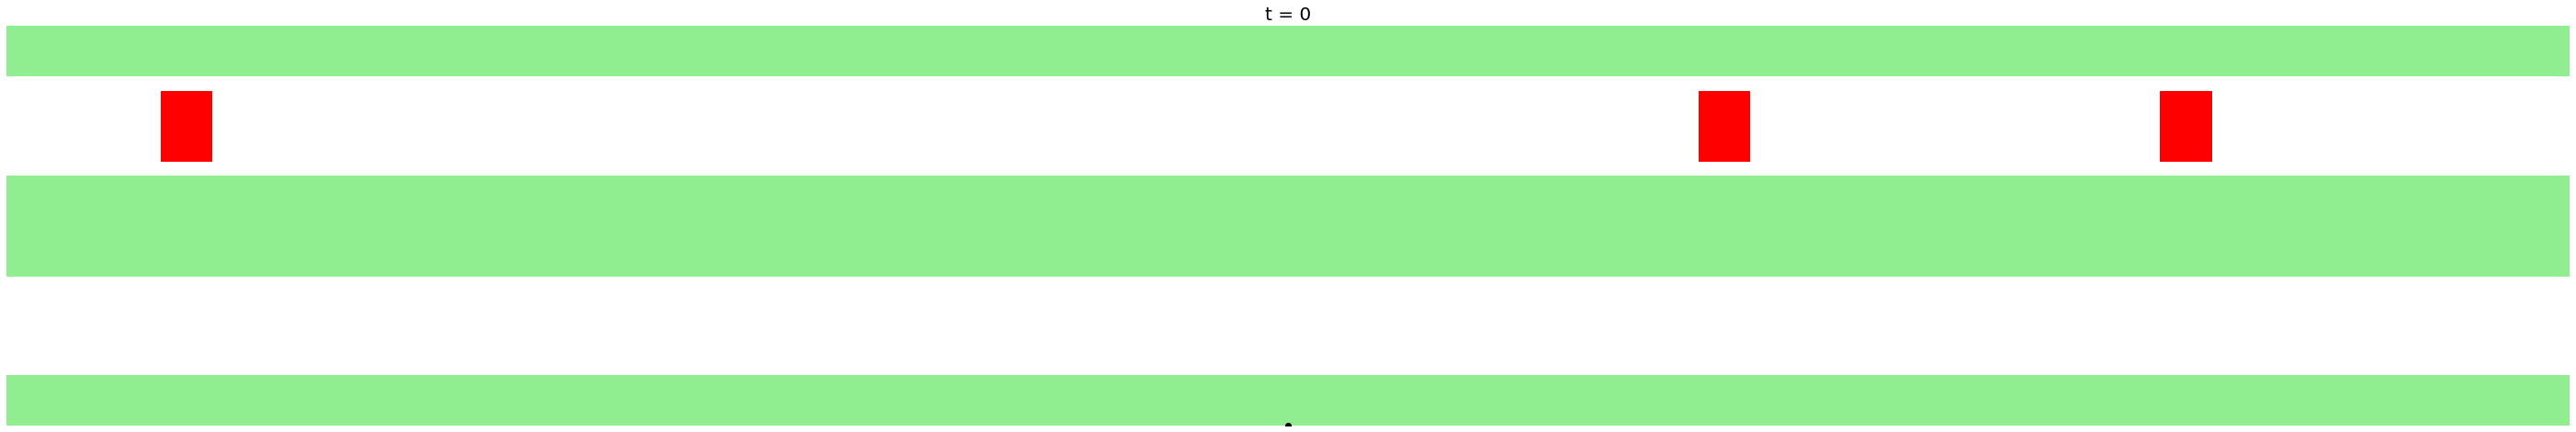

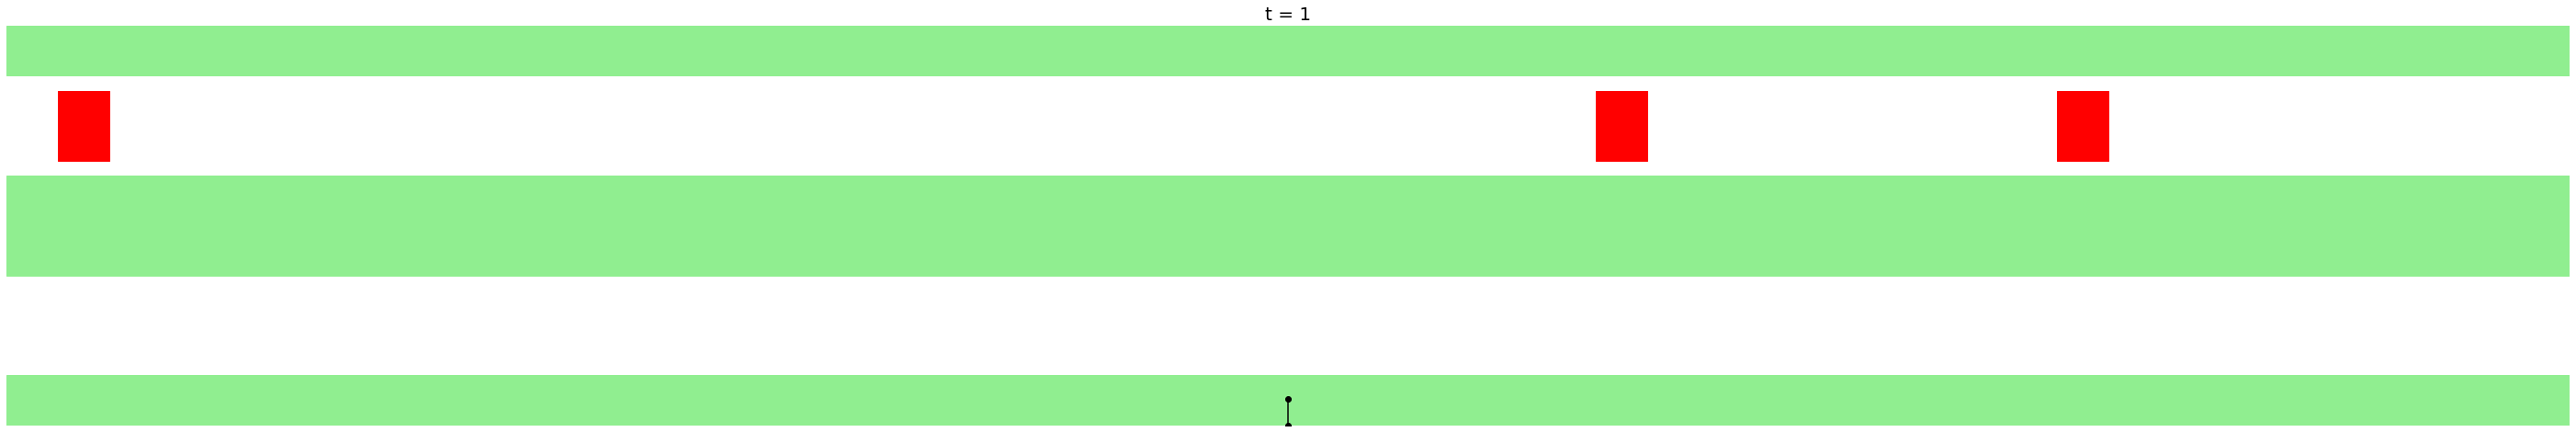

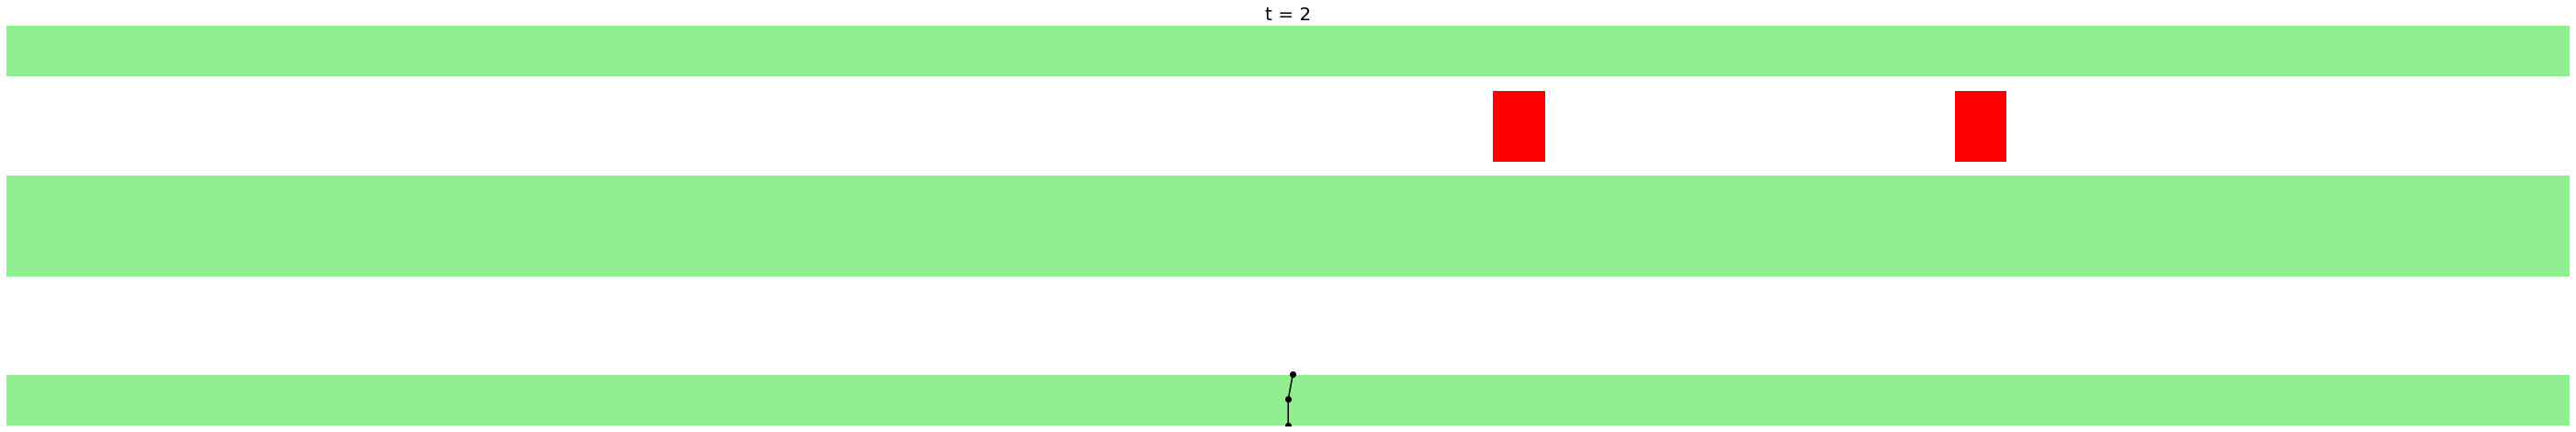

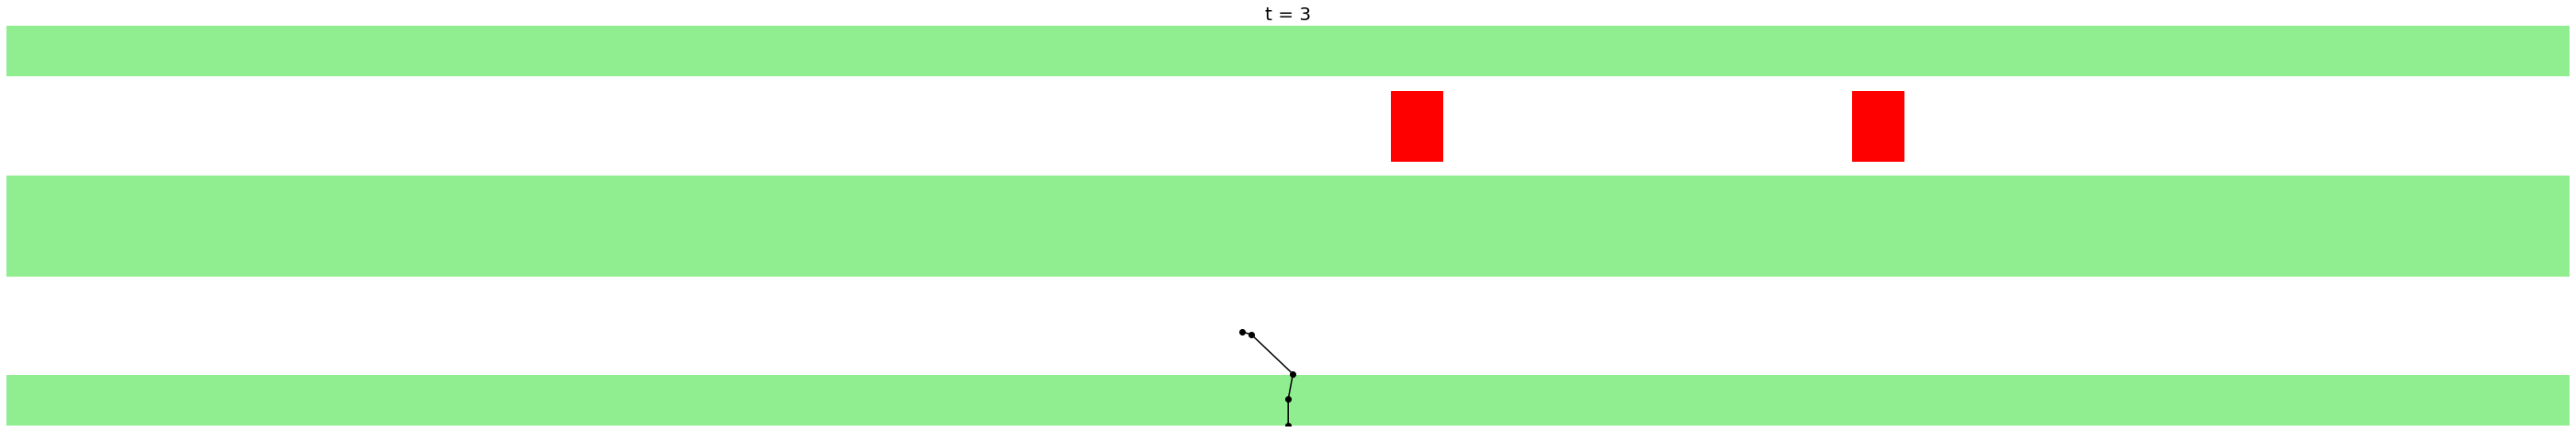

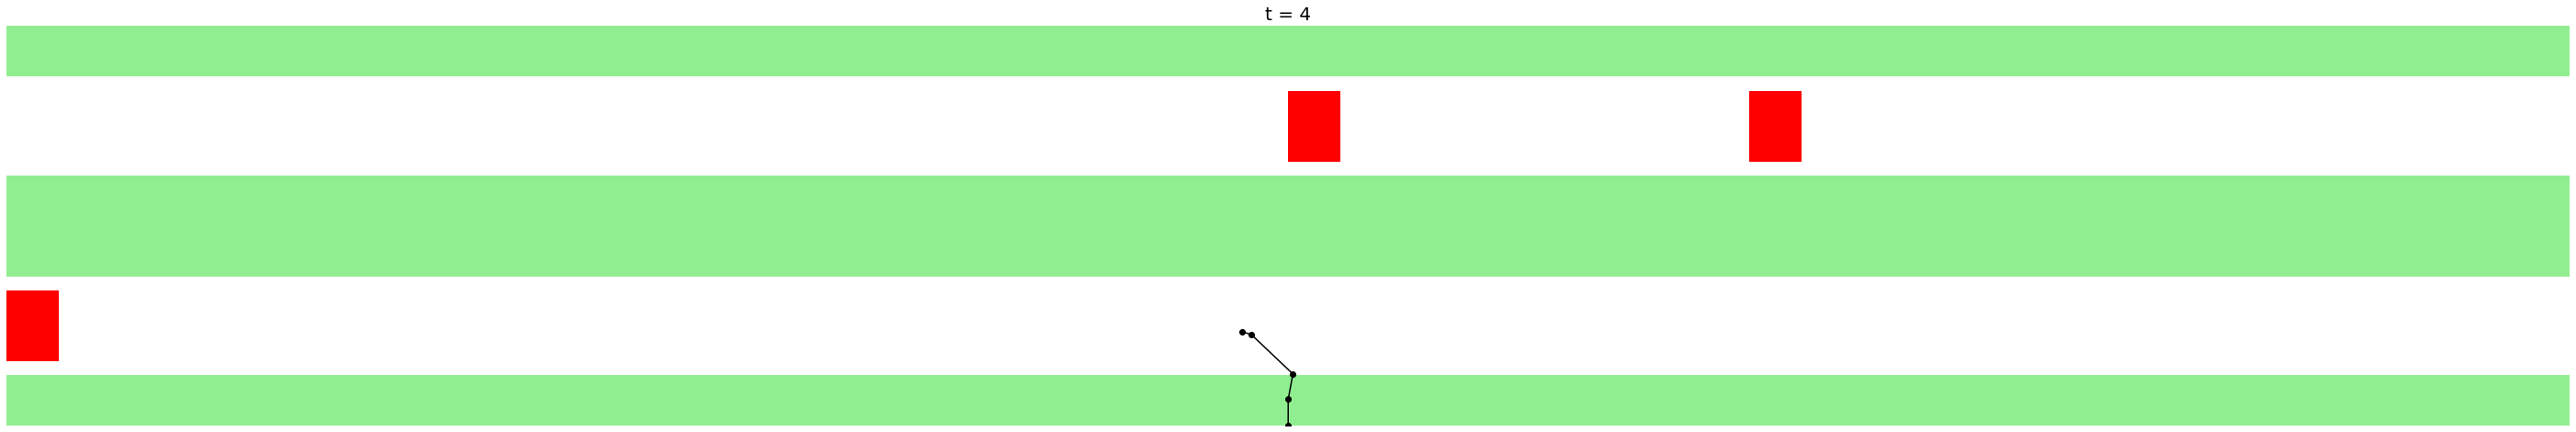

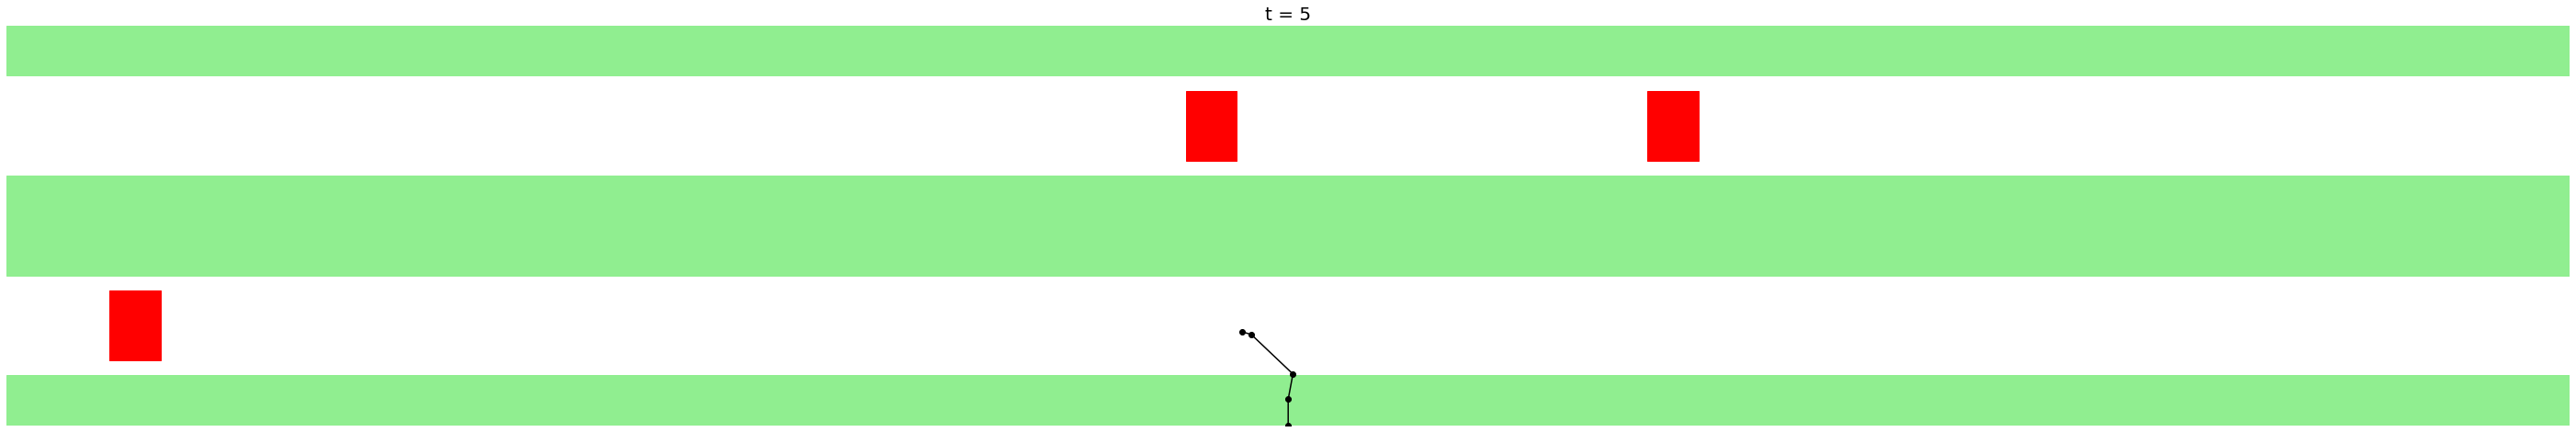

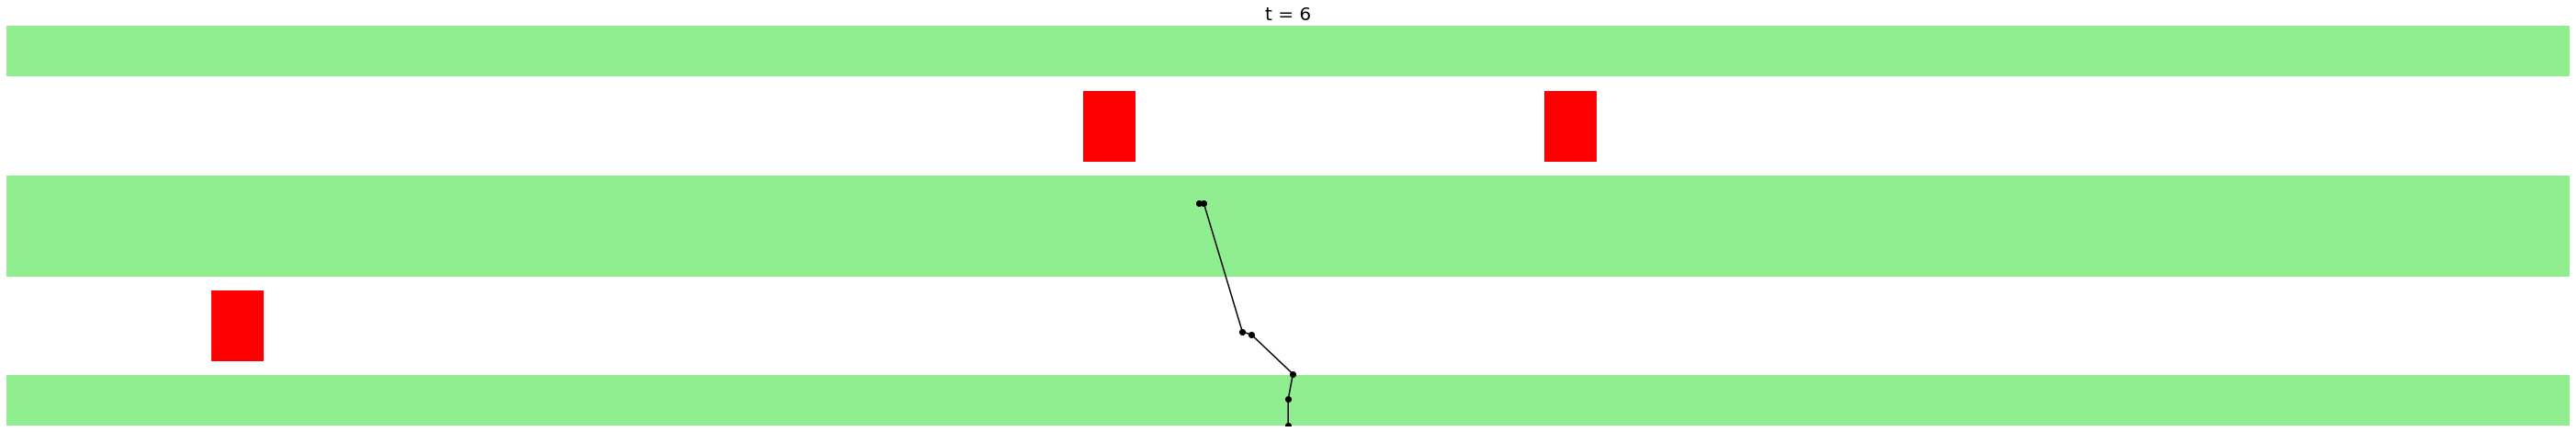

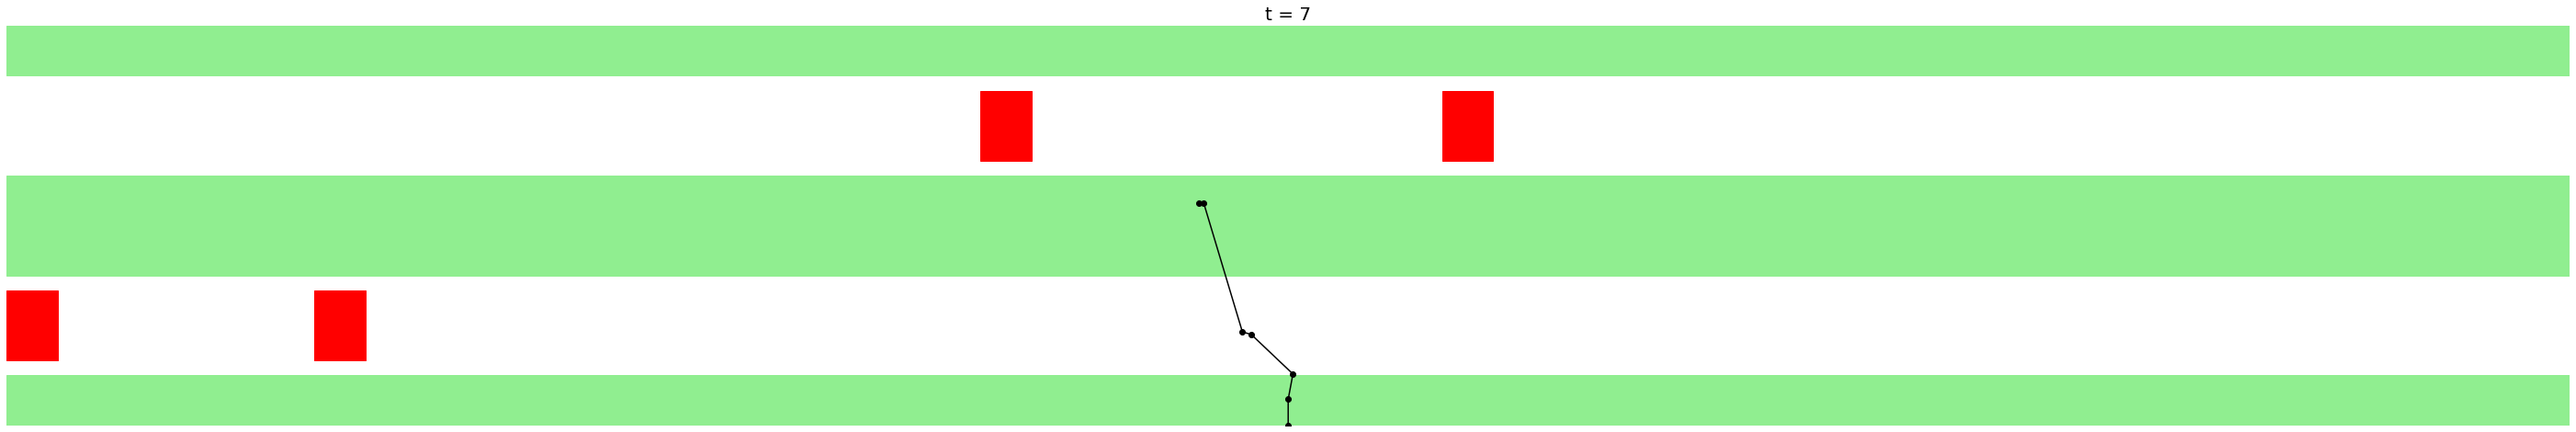

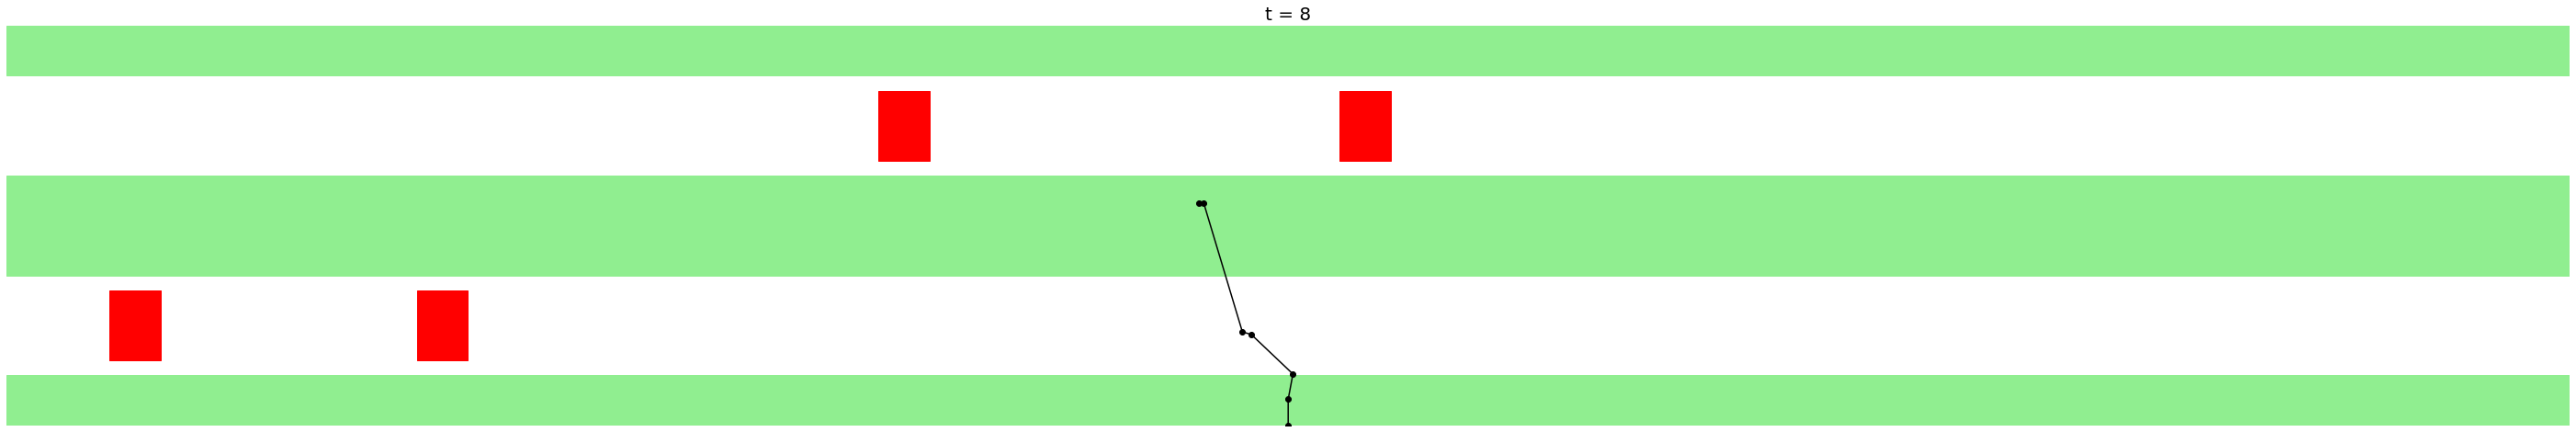

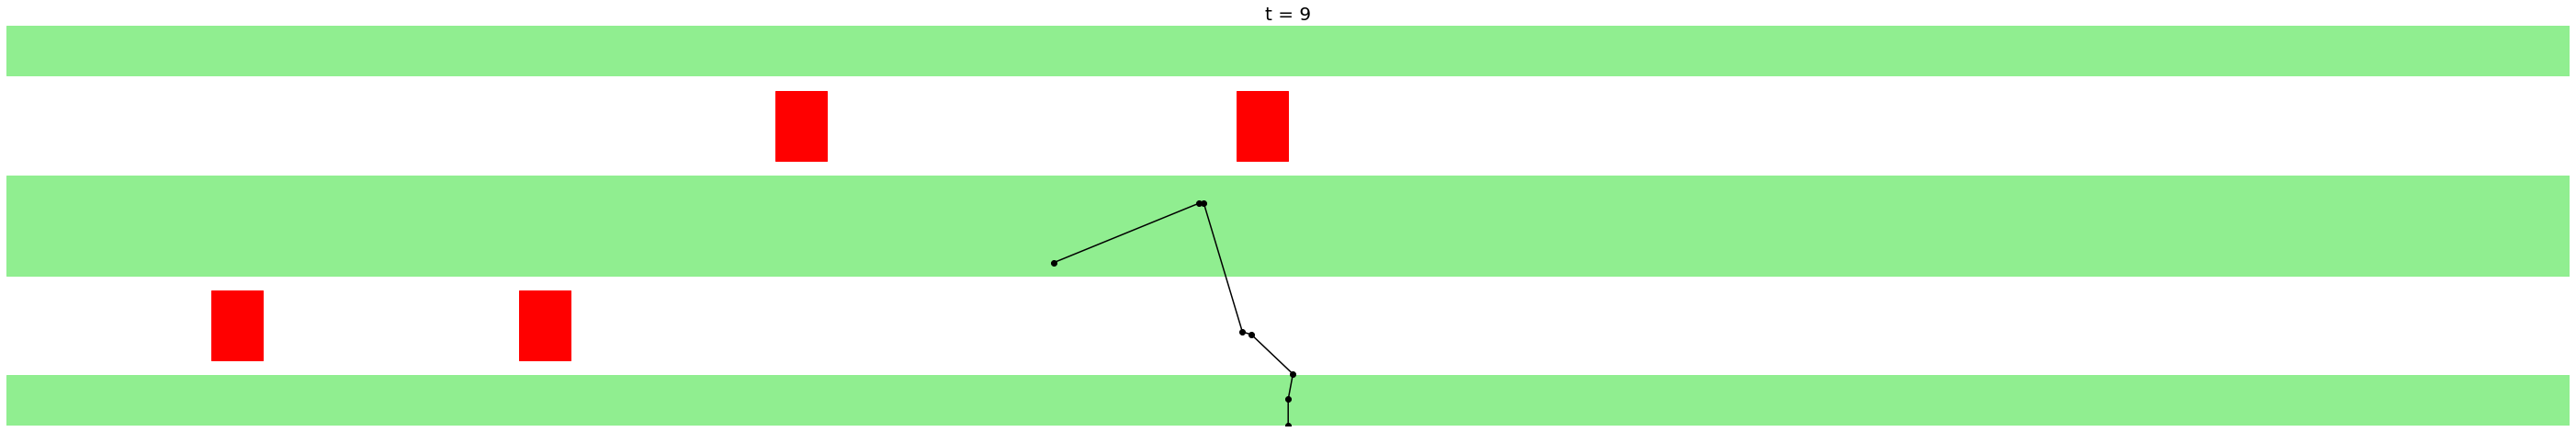

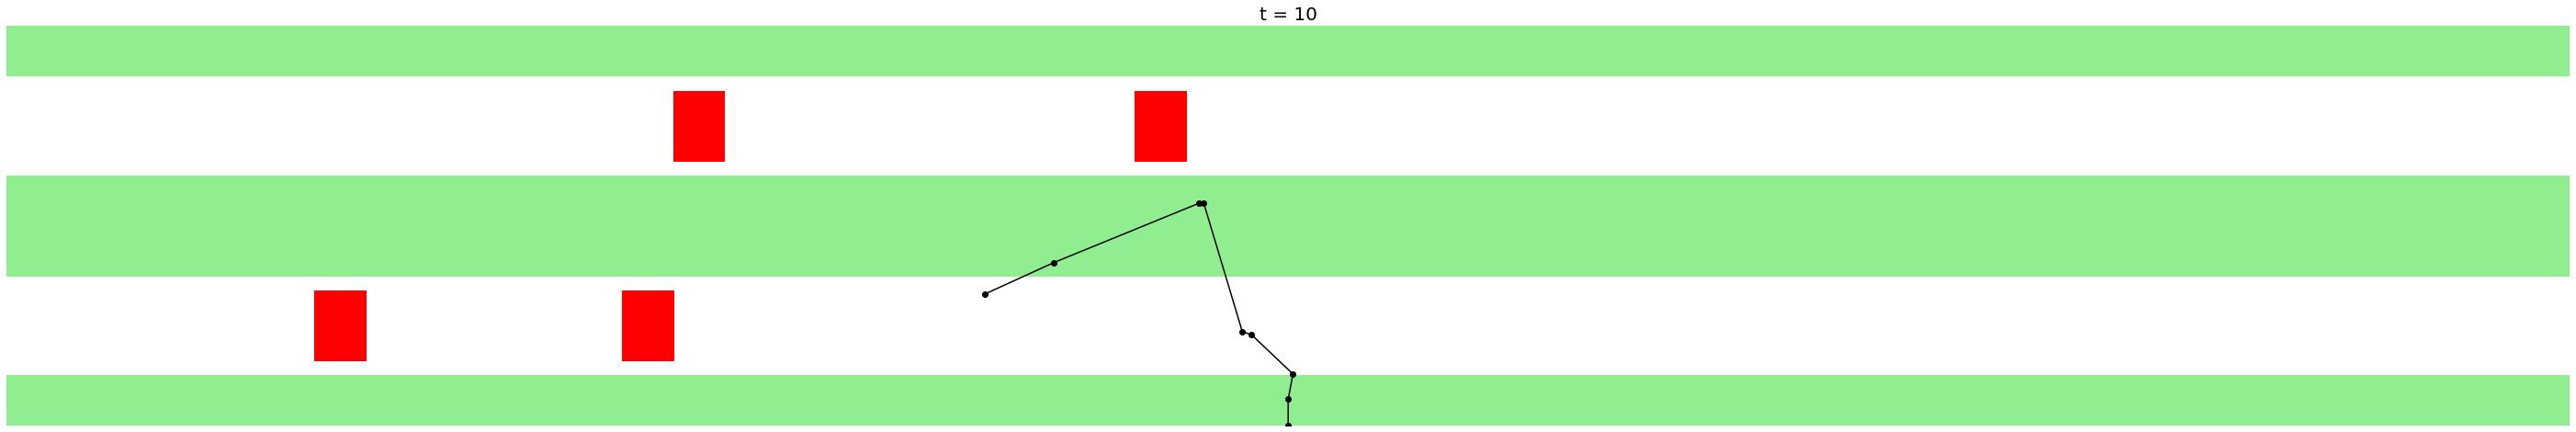

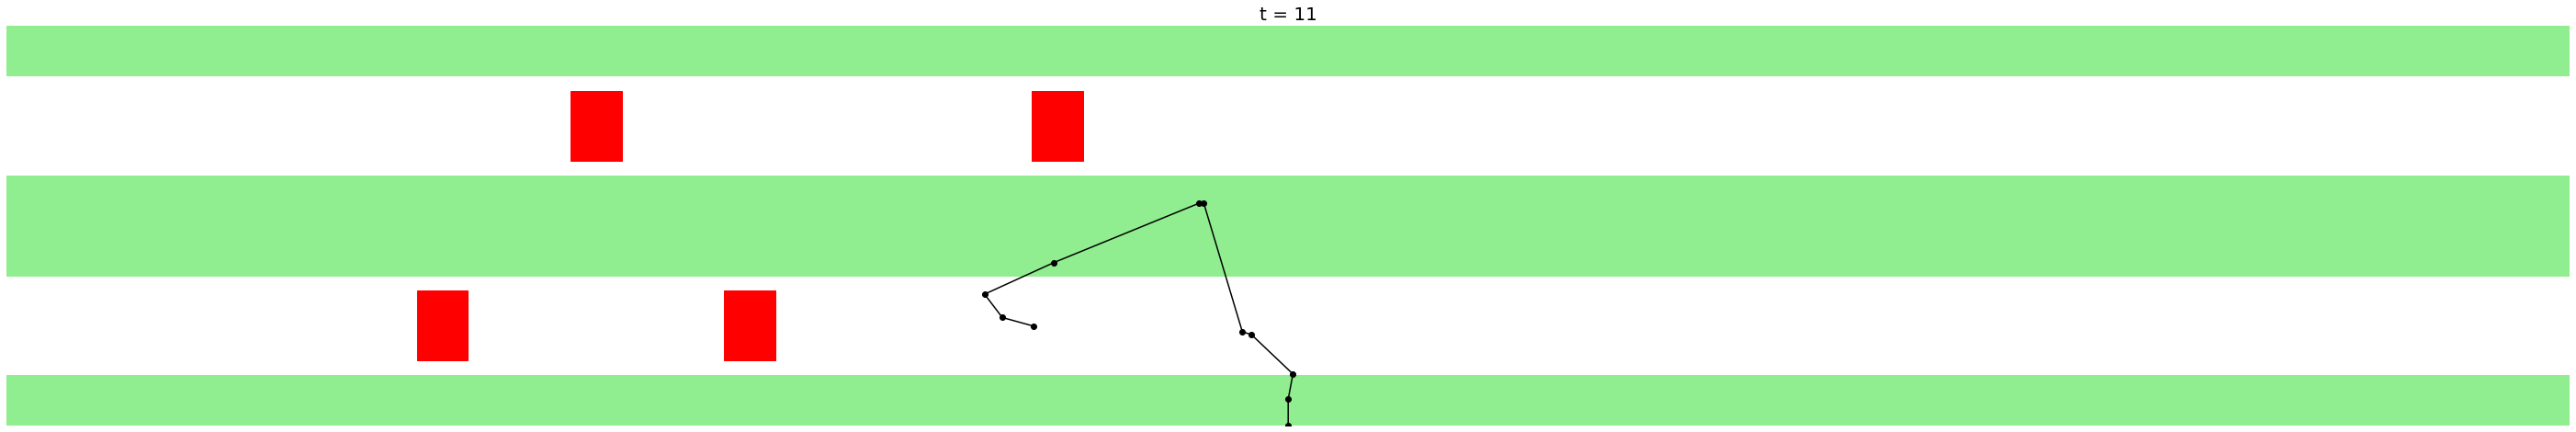

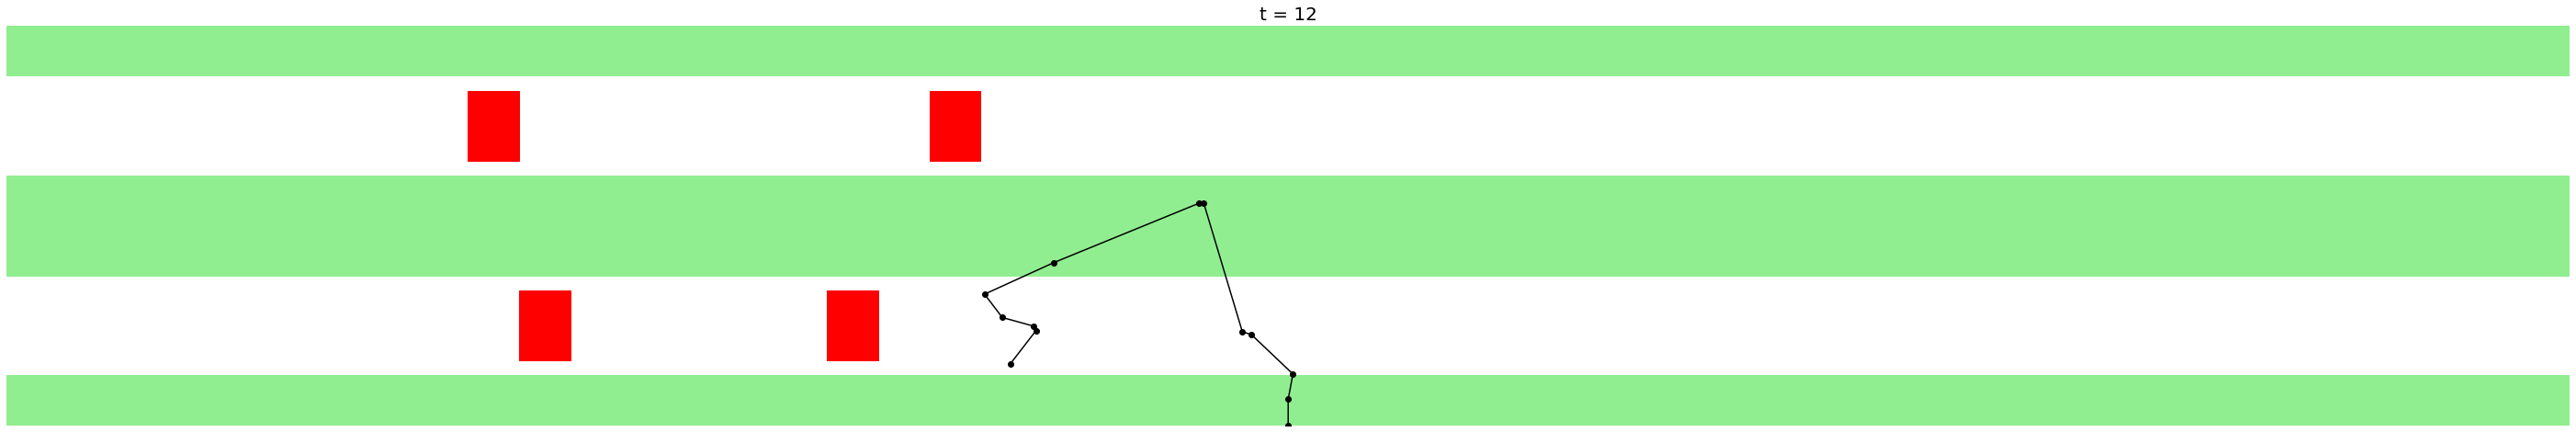

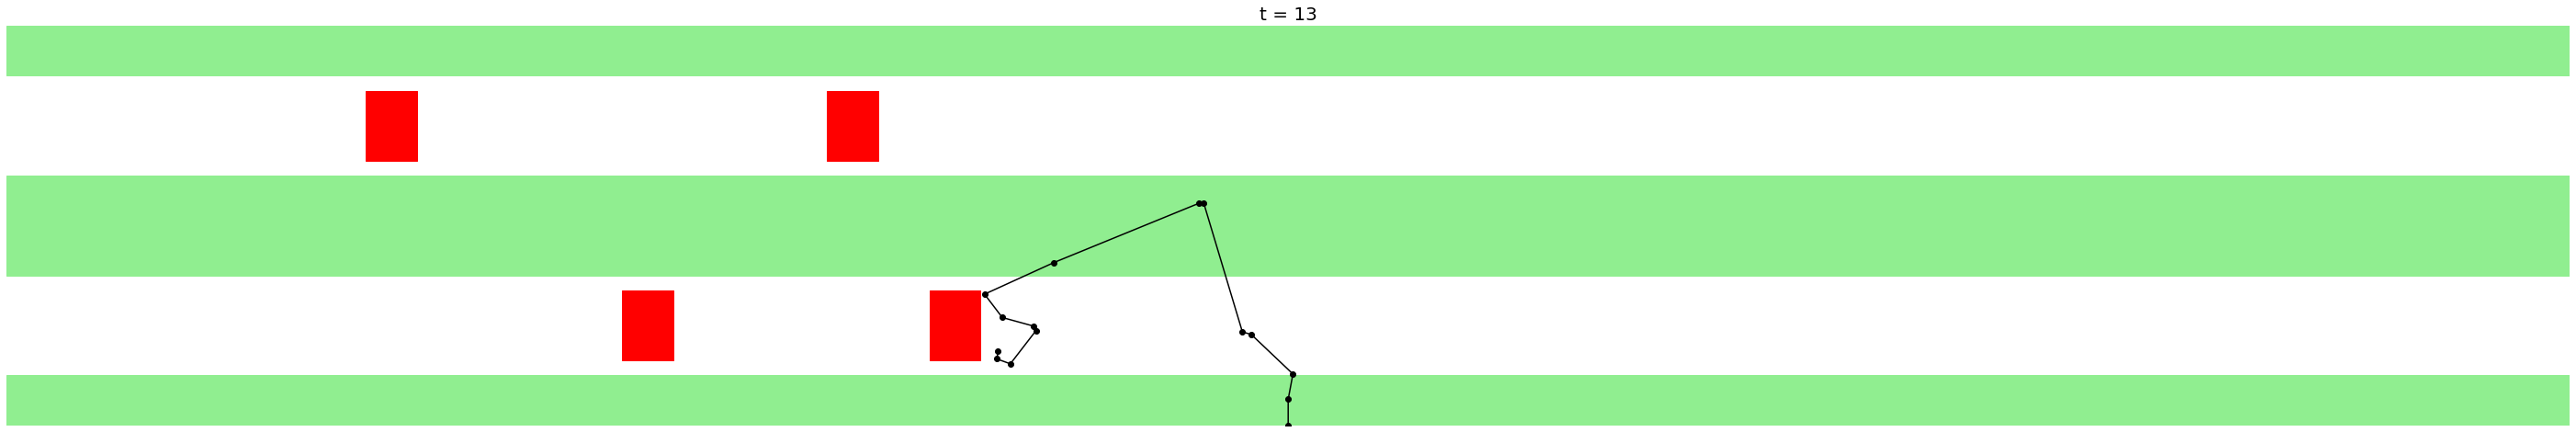

In [39]:
for i in range(timeunits+1):
    fig = plt.figure() 
    ax = fig.add_subplot(111) 

    rect1 = ptch.Rectangle((0, 0), 50, 1, color ='lightgreen') 
    rect2 = ptch.Rectangle((0, 3), 50, 2, color ='lightgreen')   
    rect3 = ptch.Rectangle((0, 7), 50, 1, color ='lightgreen') 

    ax.add_patch(rect1) 
    ax.add_patch(rect2) 
    ax.add_patch(rect3)
    j_person = plt_exp_person[plt_exp_person["time"] <= i].shape[0]
    cars = plt_exp_car[plt_exp_car["t"] == i]
    
    for j in list(cars.car1)[0]:
        rectcar1 = ptch.Rectangle((j-1, 1.3), 1, 1.4, color = "red")
        ax.add_patch(rectcar1)
    for k in list(cars.car2)[0]:
        rectcar2 = ptch.Rectangle((k, 5.3), 1, 1.4, color = "red")
        ax.add_patch(rectcar2)
        
    plt.plot(plt_exp_person.x[0:j_person], plt_exp_person.y[0:j_person], "o-", color = "black")
    plt.title("t = "+str(i), fontsize = 20)
    plt.xlim([0, 50]) 
    plt.ylim([0, 8]) 
    plt.axis('off')
    plt.show() 